In [1]:
import json
import math
from functools import partial
from pathlib import Path
from configparser import ConfigParser

import umap
import hdbscan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.graph_objs import Scatter, Layout, Heatmap
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import chart_studio
import chart_studio.plotly as py

from src.aggregator import *

pd.set_option('display.max_colwidth', -1)

C:\Users\risto\AppData\Local\Temp\ipykernel_11852\3496233029.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Configure chart studio for interactive chart hosting

In [2]:
#create your account in https://chart-studio.plotly.com/
#add credentials to 'conf/plotly.ini'
conf=ConfigParser()
conf.read('conf/plotly.ini')
username=conf['plotly']['username']
api_key=conf['plotly']['apikey']
chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

## Data

In [3]:
df=pd.read_csv('data/interim/stenos_cleaned_topics.csv')
df.shape

(209949, 22)

In [4]:
df=df[~pd.isnull(df.speaker)]
df.shape

(209938, 22)

In [5]:
#normalize factions
df['fation']=df.fation.replace({'Fraktsiooni mittekuuluvad saadikud': 'Fraktsioonidesse mittekuulunud Riigikogu liikmed',
                               'Fraktsiooni mittekuuluvad Riigikogu liikmed':'Fraktsioonidesse mittekuulunud Riigikogu liikmed'})

In [6]:
df_topic_clusters=pd.read_excel('data/interim/riigikogu_topics_clusters.xlsx')
df_topic_clusters['topic_words3']=df_topic_clusters.words.apply(lambda x: ' '.join(x.split()[:3]))
df_topic_clusters.shape

(1152, 9)

In [7]:
df_topic_clusters.head()

,topic_id,num_docs,words,x_rand,y_rand,topic_size,topic_cluster_id,color_topic_cluster,topic_words3
0,0,2836,koolis kooli opilased kool koolides opilaste opilasi koolid koolide pohikoolis,0.832609,12.465334,2836,18,darkslateblue,koolis kooli opilased
1,1,2226,oelge te saite teilt hakkasite teie olete vastake raakige tegite,1.093928,9.741197,2226,3,brown,oelge te saite
2,2,2047,komisjonis teemat kasitlenud arutatud arutanud pohjalikult arutasime teemasid temaatikat arutati,1.444144,10.505503,2047,8,darkgray,komisjonis teemat kasitlenud
3,3,2015,menetluslikud konsensuslikult konsensuslikud lugemisele menetlusotsused lugemiseks konsensuslik paevakorda novembriks taiskogule,2.818501,10.239195,2015,8,darkgray,menetluslikud konsensuslikult konsensuslikud
4,4,1963,maaran loppenud lopp lopetatud istung sulgen kell konesoove ammendatud avata,2.291581,8.136870,1963,1,blue,maaran loppenud lopp


## Colors for plotting

In [8]:
colors=json.loads(Path('utils/colors.json').read_text())
colors=list(colors.keys())[10:]

## Add topic coordinates to original data

In [9]:
df.shape

(209938, 22)

In [10]:
df=pd.merge(df, df_topic_clusters[['topic_cluster_id','topic_id', 'x_rand', 'y_rand']], 
            left_on='topic_id', right_on='topic_id', how='left')
df.shape

(209938, 25)

## Find clusters which are non-informative

In [11]:
clusters_noninform=pd.read_csv('data/interim/noninform_clusters.csv')['0'].tolist()
topics_noninform=pd.read_csv('data/interim/noninform_topics.csv')['0'].tolist()

## See top topic proportions for each faction

In [12]:
df.shape

(209938, 25)

In [13]:
df_w_factions=df[(~pd.isnull(df.fation))&(~df.topic_cluster.isin(clusters_noninform))&
                 (~df.topic_id.isin(topics_noninform))]
df_w_factions.shape

(55098, 25)

In [14]:
df_w_factions_alltops=df[(~pd.isnull(df.fation))]
df_w_factions_alltops.shape

(74390, 25)

In [15]:
df_w_factions.fation.value_counts()

Eesti Keskerakonna fraktsioon                       12429
Eesti Reformierakonna fraktsioon                    11268
Eesti Konservatiivse Rahvaerakonna fraktsioon       7860 
Sotsiaaldemokraatliku Erakonna fraktsioon           7487 
Isamaa fraktsioon                                   4442 
Fraktsioonidesse mittekuulunud Riigikogu liikmed    4254 
Isamaa ja Res Publica Liidu fraktsioon              3882 
Eesti Vabaerakonna fraktsioon                       2764 
Erakonna Eestimaa Rohelised fraktsioon              386  
Eestimaa Rahvaliidu fraktsioon                      326  
Name: fation, dtype: int64

In [16]:
N_TOPICS=df_w_factions.topic_words3.nunique()
df_faction_topics=get_group_topics_prop(df_w_factions, 'fation', n_topics_per_group=N_TOPICS)

In [17]:
df_w_factions_from2020=df_w_factions[df_w_factions.year.isin([2020, 2021, 2022])]
N_TOPICS=df_w_factions_from2020.topic_words3.nunique()
df_faction_topics_from2020=get_group_topics_prop(df_w_factions_from2020,
                                                 'fation', n_topics_per_group=N_TOPICS)

In [18]:
N_CLUSTERS=df_w_factions.topic_cluster_id.nunique()
df_faction_clusters=get_group_topics_prop(df_w_factions, 'fation', 'topic_cluster_id',
                                         n_topics_per_group=N_CLUSTERS)

In [19]:
# #the more topics the bigger the graph
# g = sns.catplot(x="count", y="topic_cluster_id", col="fation",
#                data=df_faction_clusters, color='lightblue',
#                kind="bar", col_wrap=2, sharex=True, sharey=False)

## Add visualization info to faction topics

In [20]:
df_faction_topics.shape

(2202, 4)

In [21]:
df_faction_topics=pd.merge(df_faction_topics, 
                           df_topic_clusters[['topic_words3', 'x_rand', 'y_rand', 'color_topic_cluster']],
                          on='topic_words3', how='left')
df_faction_topics.shape

(2202, 7)

In [22]:
df_faction_topics_from2020=pd.merge(df_faction_topics_from2020, 
                           df_topic_clusters[['topic_words3', 'x_rand', 'y_rand', 'color_topic_cluster']],
                          on='topic_words3', how='left')
df_faction_topics_from2020.shape

(1201, 7)

In [23]:
df_faction_clusters=pd.merge(df_faction_clusters, 
                             df_topic_clusters[['topic_cluster_id', 'x_rand', 'y_rand', 'color_topic_cluster']],
                          on='topic_cluster_id', how='left')

In [24]:
df_faction_topics.head()

,fation,topic_words3,level_2,count,x_rand,y_rand,color_topic_cluster
0,Eesti Keskerakonna fraktsioon,koolis kooli opilased,topic_words3,0.031298,0.832609,12.465334,darkslateblue
1,Eesti Keskerakonna fraktsioon,eriarstide eriarstiabi eriarsti,topic_words3,0.022608,0.470148,12.076308,darkslategray
2,Eesti Keskerakonna fraktsioon,tootuid tootute tootu,topic_words3,0.019229,0.514949,11.919371,darkslategray
3,Eesti Keskerakonna fraktsioon,alkoholi kange lahja,topic_words3,0.018022,1.315231,12.018844,darkcyan
4,Eesti Keskerakonna fraktsioon,tulumaksuvaba maksususteemi tulumaksu,topic_words3,0.016976,1.006483,12.223514,darkseagreen


In [25]:
df_faction_clusters.head()

,fation,topic_cluster_id,level_2,count,x_rand,y_rand,color_topic_cluster
0,Eesti Keskerakonna fraktsioon,6,topic_cluster_id,0.219406,1.992593,11.950748,darkcyan
1,Eesti Keskerakonna fraktsioon,6,topic_cluster_id,0.219406,1.315231,12.018844,darkcyan
2,Eesti Keskerakonna fraktsioon,6,topic_cluster_id,0.219406,1.997091,12.623475,darkcyan
3,Eesti Keskerakonna fraktsioon,6,topic_cluster_id,0.219406,1.628434,11.999760,darkcyan
4,Eesti Keskerakonna fraktsioon,6,topic_cluster_id,0.219406,1.703753,11.517861,darkcyan


In [26]:
def plot_faction_topics_scatter(df_fation_topics, faction, alpha=0.5, sizes=(20, 1000),
                               figsize=(7,7), annotate=False):
    """plot faction topics scatterplot
    -INPUT:
        -df_fation_topics: pd.DataFrame with topic and faction information
        -faction: str of faction name
        -alpha: float of transparency of eachdot
        -sizes: tule of ints with scale for dots scale
        'figsize: tuple of ints with plot size
        -annotate: bool, add names of the topics to plot
    -OUTPUT:
        -plot with faction topics in semantic similarity space, each dot/bubble size shows 
        how many texts in that topic is"""
    df_fation_topics_sub=df_fation_topics[df_fation_topics.fation==faction]
    df_fation_topics_sub=df_fation_topics_sub.reset_index()
    fig, ax =plt.subplots(figsize=figsize)
    sns.scatterplot(x=df_fation_topics_sub['x_rand'], y=df_fation_topics_sub['y_rand'], ax=ax, 
                    size=df_fation_topics_sub['count'],
                   hue=df_fation_topics_sub['color_topic_cluster'], 
                    palette=df_fation_topics_sub['color_topic_cluster'].unique().tolist(),
                   sizes=sizes, alpha=alpha)
    if annotate:
        for i in range(df_fation_topics_sub.shape[0]):
            plt.text(x=df_fation_topics_sub['x_rand'][i],y=df_fation_topics_sub['y_rand'][i],
                     s=df_fation_topics_sub['topic_words3'][i], 
                     fontdict=dict(color=df_fation_topics_sub['color_topic_cluster'][i], size=10))
    plt.legend(bbox_to_anchor=(1, 0.5))

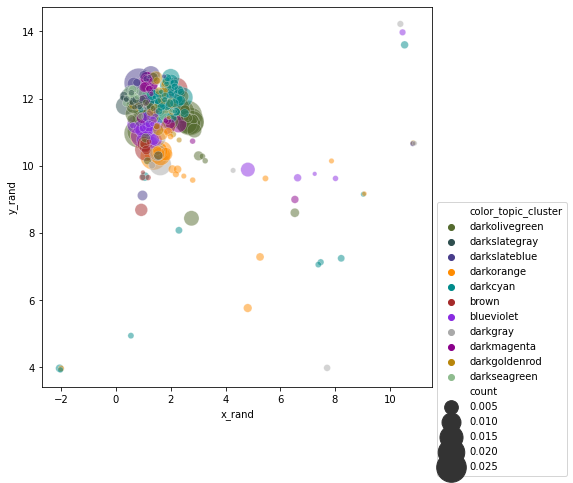

In [27]:
#matplot
plot_faction_topics_scatter(df_faction_topics, 'Eesti Konservatiivse Rahvaerakonna fraktsioon')

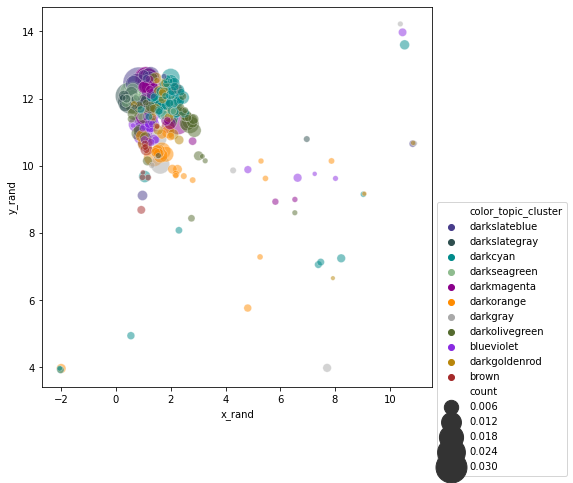

In [28]:
plot_faction_topics_scatter(df_faction_topics, 'Eesti Keskerakonna fraktsioon')

In [29]:
def plot_faction_topics_scatter_plotly(df_fation_topics, faction, n_top_topics=30, 
                                       save_folder='visualisations', marker_size_factor=1000, 
                                       marker_size_col='count', x_col='x_rand', y_col='y_rand', 
                                       topic_name_col='topic_words3', 
                                       topic_cluster_color_col='color_topic_cluster',
                                       send2plotly_server=True):
    """plot faction topics in  interactive plotly scatterplot 
    -INPUT:
        -df_fation_topics: pd.DataFrame with topic and faction information
        -faction: str of faction name
        -n_top_topics: int, number of top topics to be plotted
        -marker_size_factor: int for indicatin how big bubble each topic is
        -marker_size_col: str of column in df_fation_topics which is used for bubble size
        -x_col: str, name of the column in df_fation_topics used as x-coordinate
        -y_col: str, name of the column in df_fation_topics used as y-coordinate
        -topic_name_col: str, name of the column in df_fation_topics used to display topic name
        -topic_cluster_color_col: str, name of the column in df_fation_topics used 
            to display cluster (bubble) column
        -send2plotly_server: bool, send chart to plotly server
    -OUTPUT:
        -plot with faction topics in semantic similarity space, each dot/bubble size shows 
        how many texts in that topic is. Saves plot in save_folder in html and if send2plotly_server True sends to 
        plotly server"""
    df_fation_topics_sub=df_fation_topics[df_fation_topics.fation==faction]
    df_fation_topics_sub=df_fation_topics_sub.head(n_top_topics)
    # Create a trace containing the scatter plot
    scatter = go.Scatter(x = df_fation_topics_sub[x_col], 
                         y = df_fation_topics_sub[y_col], 
                         mode = 'markers', \
                       marker= dict(size= df_fation_topics[marker_size_col]*marker_size_factor, 
                                    color = df_fation_topics_sub[topic_cluster_color_col],\
                                    line = dict(width = 2, color = 'rgb(0, 0, 0)'),
                                    opacity=0.5),
                       text = df_fation_topics_sub[topic_name_col]+
                         ' % of segments '+(df_fation_topics_sub[marker_size_col]*100).round(3).astype(str))

    # Collect the trace(s) into the data to be plotted.
    data = [scatter]

    # Edit the layout
    layout = dict(title = f'{faction} top {n_top_topics} teemat',
                  xaxis = dict(title = 'x'),
                  yaxis = dict(title = 'y'),
                  hovermode = 'closest',
                  )

    # Define the figure
    fig = dict(data=data, layout=layout)

    # Save figure and layout into html file
    plot_url = plotly.offline.plot(fig, filename=f'{save_folder}/{faction.replace(" ", "_")}_topic_embeddings.html')
    if send2plotly_server:
        py.plot(fig, filename=faction.replace(" ", "_")+'_topic_embeddings', auto_open = True)

In [30]:
plot_faction_topics_scatter_plotly(df_faction_topics, 'Eesti Konservatiivse Rahvaerakonna fraktsioon')

In [31]:
plot_faction_topics_scatter_plotly(df_faction_topics, 'Eesti Keskerakonna fraktsioon')

In [32]:
plot_faction_topics_scatter_plotly(df_faction_topics, 'Eesti Reformierakonna fraktsioon')

In [33]:
plot_faction_topics_scatter_plotly(df_faction_topics, 'Sotsiaaldemokraatliku Erakonna fraktsioon')

In [34]:
plot_faction_topics_scatter_plotly(df_faction_topics, 'Isamaa fraktsioon')

### one plot for all factions

In [35]:
def plot_group_topics_scatter_plotly(df_group_topics, group_col='fation', groups2keep=None, n_top_topics=10, 
                                     save_file='visualisations/faction_topic_embedding.html', n_col=2, 
                                     marker_size_factor=1000, 
                                     marker_size_col='count', x_col='x_rand', y_col='y_rand', 
                                     topic_name_col='topic_words3', 
                                     topic_cluster_color_col='color_topic_cluster',
                                     width=1000, height=1500, margin_add=0.2,
                                     name_in_plotly='factions_topic_embedding',
                                     send2plotly_server=True):
    """plot faction topics in  interactive plotly scatterplot 
    -INPUT:
        -df_group_topics: pd.DataFrame with topic and group information
        -group_col: str of group column
        -groups2keep: list of group values to keep in plotting
        -n_top_topics: int, number of top topics to be plotted
        -save_file: str of file where plot is saved
        -n_col: int of number of columns in facet
        -marker_size_factor: int for indicatin how big bubble each topic is
        -marker_size_col: str of column in df_fation_topics which is used for bubble size
        -x_col: str, name of the column in df_fation_topics used as x-coordinate
        -y_col: str, name of the column in df_fation_topics used as y-coordinate
        -topic_name_col: str, name of the column in df_fation_topics used to display topic name
        -topic_cluster_color_col: str, name of the column in df_fation_topics used 
            to display cluster (bubble) column
        -width: int of width of plot
        -height: int of height of plot
        -margin_add: float or margin to be removed from min and added max x and y values for plotting
        -name_in_plotly: str name of the name graph in plotly server
        -send2plotly_server: bool, send chart to plotly server
    -OUTPUT:
        -plot with groups topics in semantic similarity space, each dot/bubble size shows 
        how many texts in that topic is. Saves plot in save_folder in html and if send2plotly_server True sends to 
        plotly server"""
    
    df_group_topics_head=df_group_topics.groupby(group_col).head(n_top_topics)
    if groups2keep is not None:
        df_group_topics_head=df_group_topics_head[df_group_topics_head[group_col].isin(groups2keep)]

    unique_levels=df_group_topics_head[group_col].unique()
    n_unique_levels=len(unique_levels)
    n_row=math.ceil(n_unique_levels/2)
    fig = make_subplots(n_row, n_col, 
                        subplot_titles=[f'{unique_levels[i]}' for i in range(n_unique_levels)])
    row_i=0
    col_i=1
    for i in range(1, n_unique_levels+1):
        if i%2!=0:
            row_i+=1
            col_i=1
        else:
            col_i=2
        df_group_topics_sub=df_group_topics_head[df_group_topics_head[group_col]==unique_levels[i-1]]
        scatter=go.Scatter(x = df_group_topics_sub[x_col], 
                             y = df_group_topics_sub[y_col], 
                             mode = 'markers', \
                           marker= dict(size= df_group_topics_sub[marker_size_col]*marker_size_factor, 
                                        color = df_group_topics_sub[topic_cluster_color_col],\
                                        line = dict(width = 2, color = 'rgb(0, 0, 0)'),
                                        opacity=0.5),
                           text = df_group_topics_sub[topic_name_col]+
                             ' % of segments '+(df_group_topics_sub[marker_size_col]*100).round(3).astype(str))
        fig.add_trace(scatter, row_i, col_i)

    fig.update_layout(
        autosize=False,
        showlegend=False,
        width=width,
        height=height)

    fig.update_xaxes(range=[df_group_topics_head[x_col].min()-margin_add, df_group_topics_sub[x_col].max()+margin_add])
    fig.update_yaxes(range=[df_group_topics_head[y_col].min()-margin_add, df_group_topics_sub[y_col].max()+margin_add])
    #fig.show()
    plot_url = plotly.offline.plot(fig, filename=save_file)
    if send2plotly_server:
        py.plot(fig, filename=name_in_plotly, auto_open = True)

In [36]:
factions2keep={'Eesti Keskerakonna fraktsioon':'Keskerakond',
               'Eesti Konservatiivse Rahvaerakonna fraktsioon':'EKRE',
               'Eesti Reformierakonna fraktsioon':'Reformierakond',
               'Isamaa fraktsioon':'Isamaa',
               'Sotsiaaldemokraatliku Erakonna fraktsioon':'Sotsiaaldemokraadid',
               'Fraktsioonidesse mittekuulunud Riigikogu liikmed': 'Fraktsioonitud'}

df_faction_topics['faction']=df_faction_topics.fation
df_faction_topics['faction_short']=df_faction_topics['faction'].replace(factions2keep)
plot_group_topics_scatter_plotly(df_faction_topics, group_col='faction_short',
                                 groups2keep=list(factions2keep.values()),
                                n_top_topics=10, margin_add=1.0)

In [37]:
df_faction_topics_from2020['faction']=df_faction_topics_from2020.fation
df_faction_topics_from2020['faction_short']=df_faction_topics_from2020['faction'].replace(factions2keep)
plot_group_topics_scatter_plotly(df_faction_topics_from2020, group_col='faction_short',
                                 groups2keep=list(factions2keep.values()),
                                n_top_topics=10, margin_add=1.0,
                                save_file='visualisations/faction_topic_embedding_from2020.html',
                                name_in_plotly='factions_topic_embedding_from2020')

## Faction topic proportions

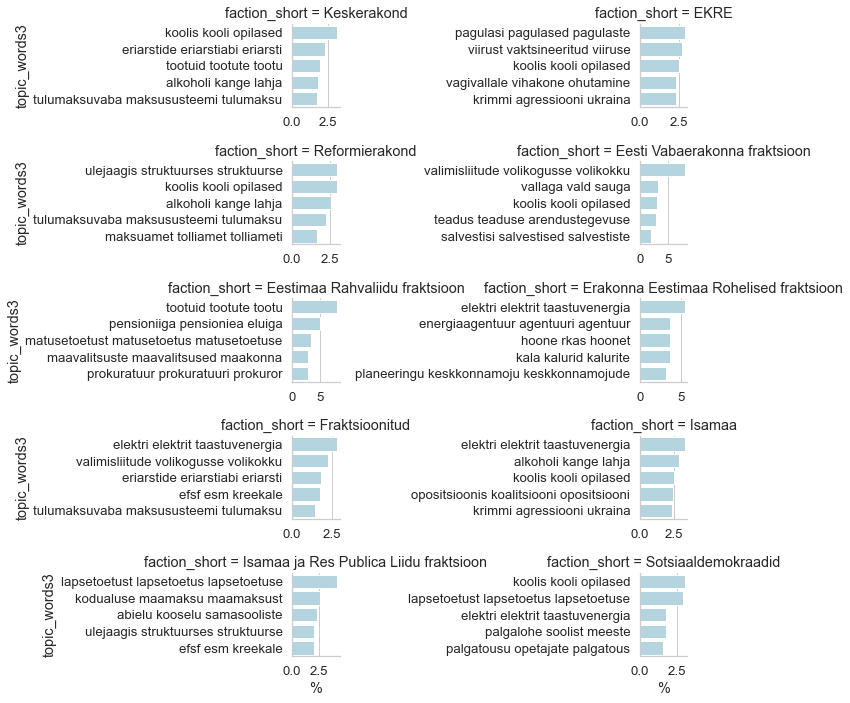

In [38]:
df_faction_topics['proportion']=df_faction_topics['count']*100
    
plot_catplot(df_faction_topics.groupby(['faction']).head(), 
             'proportion', 'topic_words3', 'faction_short', '%', 
             'visualisations/png/faction_topic_proportions.png',
             font_scale=1.2, sns_style='whitegrid', sharex=False,
             sharey=False, color='lightblue', col_wrap=2,
             height=2., aspect=2.5)

In [39]:
df_faction_topics.fation.unique()

array(['Eesti Keskerakonna fraktsioon',
       'Eesti Konservatiivse Rahvaerakonna fraktsioon',
       'Eesti Reformierakonna fraktsioon',
       'Eesti Vabaerakonna fraktsioon', 'Eestimaa Rahvaliidu fraktsioon',
       'Erakonna Eestimaa Rohelised fraktsioon',
       'Fraktsioonidesse mittekuulunud Riigikogu liikmed',
       'Isamaa fraktsioon', 'Isamaa ja Res Publica Liidu fraktsioon',
       'Sotsiaaldemokraatliku Erakonna fraktsioon'], dtype=object)

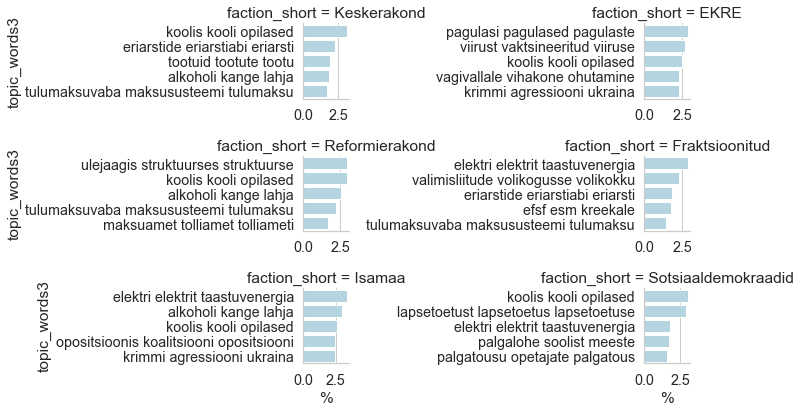

In [40]:
df_faction_topics_sub=df_faction_topics[df_faction_topics.faction_short.isin(
    list(factions2keep.values()))]
    
plot_catplot(df_faction_topics_sub.groupby(['faction_short']).head(5), 
             'proportion', 'topic_words3', 'faction_short', '%', 
             'visualisations/png/faction_subset__topic_proportions.png',
             font_scale=1.3, sns_style='whitegrid', sharex=False,
             sharey=False, color='lightblue', col_wrap=2,
             height=2., aspect=2.5)

## Create topics vector for each faction

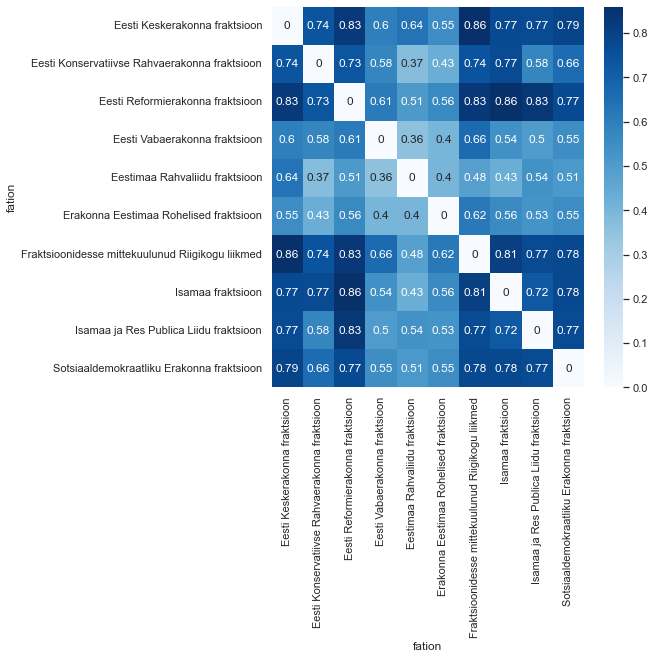

In [41]:
#this is for comparison how does removing non-informative topics affect results
df_faction_all_topic_vecs, df_faction_all_topic_cossim=create_plot_group_topvecs(
    df_w_factions_alltops, 
    df_w_factions_alltops.topic_words3.nunique(),
    fillna=0)

In [45]:
df_w_factions_alltops_sub=df_w_factions_alltops[df_w_factions_alltops.fation.isin(factions2keep)]
df_w_factions_alltops_sub['faction_short']=df_w_factions_alltops_sub['fation'].replace(factions2keep)

C:\Users\risto\AppData\Local\Temp\ipykernel_11852\2329853487.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



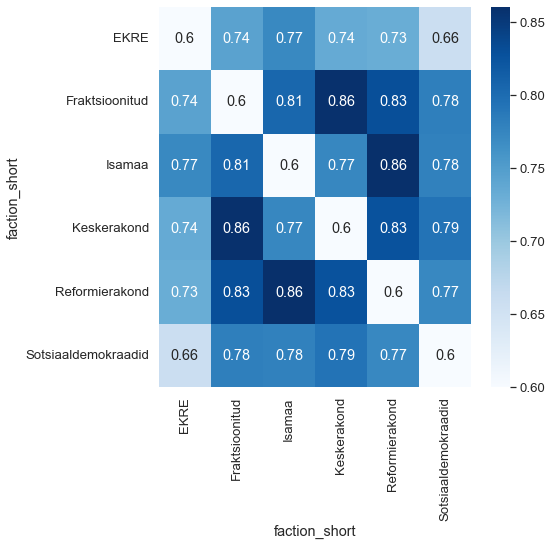

In [56]:
df_faction_sub_topic_vecs, df_faction_sub_topic_cossim=create_plot_group_topvecs(
    df_w_factions_alltops_sub,
    df_w_factions_alltops_sub.topic_words3.nunique(),
    group_col='faction_short',
    fillna=0,
    fill_diag_value=0.6, font_scale=1.2)

In [57]:
df_faction_sub_topic_cossim.mean(axis=1)

faction_short
EKRE                   0.706890
Fraktsioonitud         0.769843
Isamaa                 0.764997
Keskerakond            0.764301
Reformierakond         0.770028
Sotsiaaldemokraadid    0.730662
dtype: float64

In [58]:
df_faction_sub_topic_cossim.median(axis=1)

faction_short
EKRE                   0.733487
Fraktsioonitud         0.793257
Isamaa                 0.776295
Keskerakond            0.782823
Reformierakond         0.799091
Sotsiaaldemokraadid    0.775744
dtype: float64

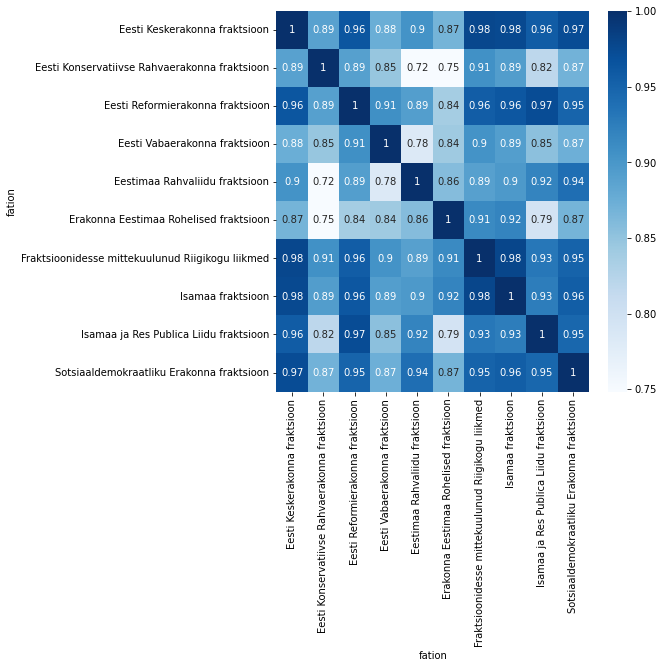

In [29]:
#if we use only clusters of topics does it change anything?
df_faction_all_cluster_vecs, df_faction_all_cluster_cossim=create_plot_group_topvecs(
    df_w_factions_alltops, 
    df_w_factions_alltops.topic_cluster_id.nunique(),
    topic_col='topic_cluster_id',
    fillna=0,
    fill_diag_value=1)#diagonal is filled with 1 because most values are close to it,
                        #makes visually easier to see patterns

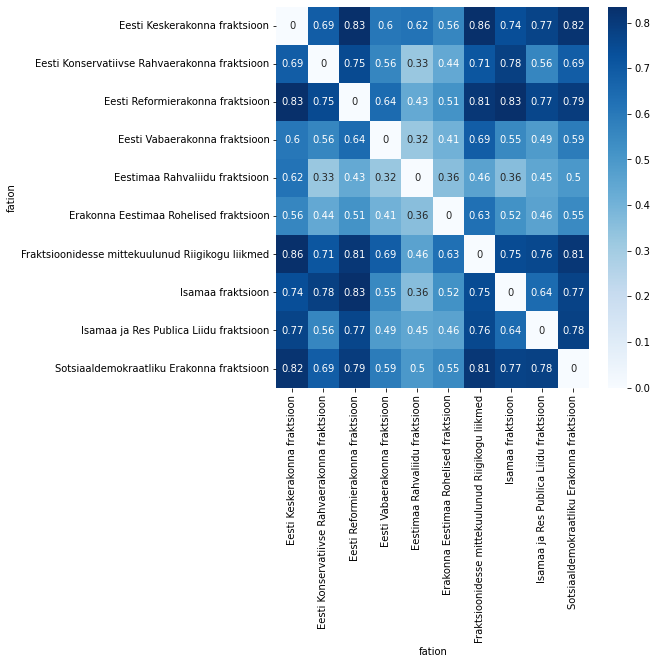

In [30]:
#kept only meaningful topics
df_faction_topic_vecs, df_faction_topic_cossim=create_plot_group_topvecs(df_w_factions, N_TOPICS, fillna=0)

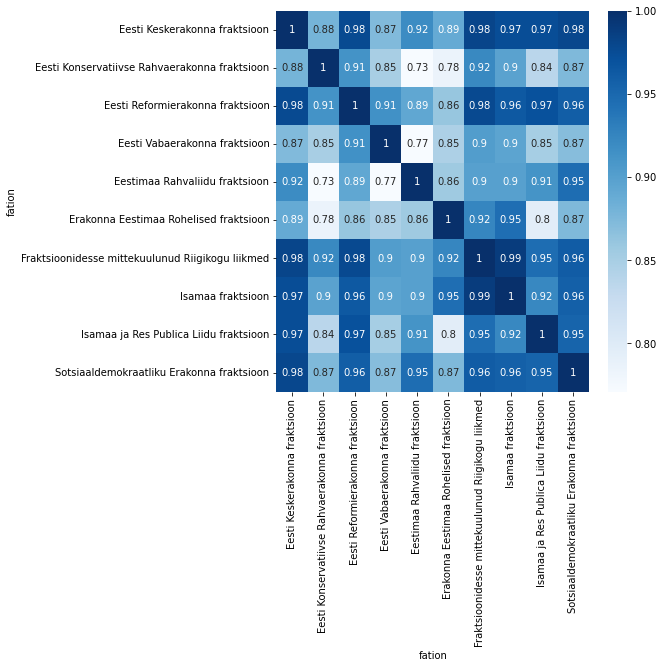

In [31]:
#clusters if kept kept only meaninguful topics
df_faction_cluster_vecs, df_faction_cluster_cossim=create_plot_group_topvecs(
    df_w_factions,   
    df_w_factions_alltops.topic_cluster_id.nunique(),
    topic_col='topic_cluster_id',
    fillna=0, 
    fill_diag_value=1)#diagonal is filled with 1 because most values are close to it,
                        #makes visually easier to see patterns

<AxesSubplot:ylabel='fation'>

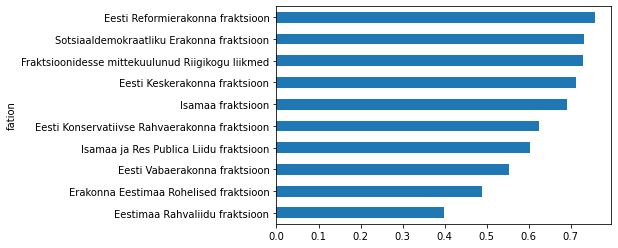

In [32]:
df_faction_topic_cossim.median(axis=1).sort_values().plot(kind='barh')

<AxesSubplot:ylabel='fation'>

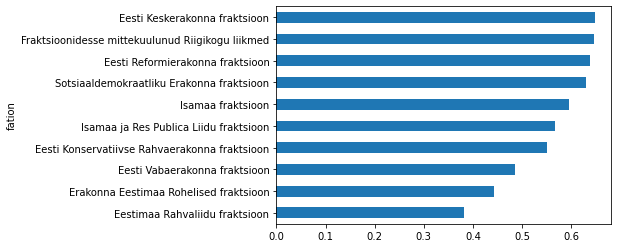

In [33]:
df_faction_topic_cossim.mean(axis=1).sort_values().plot(kind='barh')

## See some similar topics of factions

#### Save data for FS tool anlaysis

In [39]:
df_faction_topic_vecs.to_csv('data/interim/trending/factions/faction_topic_vecs.csv')

In [40]:
simdiff_kesk_ref=pd.read_csv('data/interim/trending/factions/simdiff_kesk_ref.csv')
simdiff_ekre_ref=pd.read_csv('data/interim/trending/factions/simdiff_ekre_ref.csv')
simdiff_isamaa_ref=pd.read_csv('data/interim/trending/factions/simdiff_isamaa_ref.csv')
simdiff_sotsid_ref=pd.read_csv('data/interim/trending/factions/simdiff_sotsid_ref.csv')
simdiff_isamaa_ekre=pd.read_csv('data/interim/trending/factions/simdiff_isamaa_ekre.csv')

In [41]:
simdiff_kesk_ref.head(20)

,topic_words3,Eesti Keskerakonna fraktsioon,Eesti Reformierakonna fraktsioon,difference
0,ulejaagis struktuurses struktuurse,0.008207,0.029730,-262.271346
1,viirust vaktsineeritud viiruse,0.003621,0.012691,-250.520057
2,samba sammas sambasse,0.002333,0.010472,-348.821196
3,maksuamet tolliamet tolliameti,0.006437,0.016507,-156.455671
4,jarviku jarvik maaeluministri,0.004345,0.012070,-177.801444
5,untso missioonide liikmesusest,0.002333,0.008253,-253.731960
6,krimmi agressiooni ukraina,0.007563,0.015886,-110.046054
7,salvestisi salvestised salvestiste,0.004747,0.011005,-131.824335
8,teadus teaduse arendustegevuse,0.003379,0.008520,-152.122319
9,arengukavad arengukavade pohialuste,0.007563,0.013578,-79.536571


In [42]:
simdiff_kesk_ref.tail(20)

,topic_words3,Eesti Keskerakonna fraktsioon,Eesti Reformierakonna fraktsioon,difference
235,lapsetoetust lapsetoetus lapsetoetuse,0.011103,0.005680,48.844747
236,hambaravi hammaste hambad,0.004425,0.000710,83.955852
237,matusetoetust matusetoetus matusetoetuse,0.004667,0.000887,80.982153
238,maavalitsuste maavalitsused maakonna,0.007322,0.002574,64.848331
239,pensioniiga pensioniea eluiga,0.008287,0.003106,62.518223
240,vaesuses suhtelises vaesuse,0.007322,0.002130,70.908963
241,teede teehoiuks teedele,0.011505,0.004881,57.575571
242,omandireformi tagastatud omandireform,0.007161,0.001686,76.452059
243,vallaga vald sauga,0.010057,0.003461,65.585304
244,kodualuse maamaksu maamaksust,0.011505,0.004260,62.975044


In [43]:
simdiff_ekre_ref.head(20)

,topic_words3,Eesti Reformierakonna fraktsioon,Eesti Konservatiivse Rahvaerakonna fraktsioon,difference
0,pagulasi pagulased pagulaste,0.001775,0.028626,-1512.786260
1,vagivallale vihakone ohutamine,0.006301,0.022901,-263.444791
2,piirilepingu piirileping piirilepingut,0.002929,0.015140,-416.960444
3,rahvuse rahvust rahvusriik,0.005414,0.018702,-245.471155
4,liitlaste ohutorje keskmaa,0.003727,0.015903,-326.663032
5,rahvahaaletuse rahvahaaletus rahvahaaletusel,0.003372,0.015267,-352.711933
6,kauguhendus avaksite ettekandjalt,0.002662,0.013613,-411.312977
7,viirust vaktsineeritud viiruse,0.012691,0.026463,-108.521860
8,abielu kooselu samasooliste,0.005857,0.015649,-167.168633
9,piirivalve valvamise valvamine,0.000532,0.009033,-1596.412214


In [44]:
simdiff_ekre_ref.tail(20)

,topic_words3,Eesti Reformierakonna fraktsioon,Eesti Konservatiivse Rahvaerakonna fraktsioon,difference
235,majandusaasta koondaruanne raamatupidamise,0.004171,0.000636,84.749066
236,teede teehoiuks teedele,0.004881,0.001018,79.147814
237,arengukavad arengukavade pohialuste,0.013578,0.006743,50.339769
238,inimarengu aruanne aruandes,0.005502,0.001145,79.189855
239,tootuid tootute tootu,0.005946,0.001399,76.463484
240,toovoimereformi toovoimega toovoimereform,0.006479,0.000382,94.108543
241,untso missioonide liikmesusest,0.008253,0.002163,73.794632
242,arengufond arengufondi arengufondis,0.009940,0.002926,70.560251
243,alkoholi kange lahja,0.025382,0.012977,48.872044
244,samba sammas sambasse,0.010472,0.002290,78.131712


In [45]:
simdiff_isamaa_ref.head(20)

,topic_words3,Eesti Reformierakonna fraktsioon,Isamaa fraktsioon,difference
0,lng terminali gaasi,0.003816,0.016209,-324.748961
1,elektri elektrit taastuvenergia,0.016329,0.033543,-105.417164
2,uhistranspordi uhistransport uhistransporti,0.002751,0.012607,-358.241710
3,hadaolukorda eriolukord eriolukorra,0.006124,0.017109,-179.404107
4,annetused annetusi annetuste,0.002485,0.011481,-362.040908
5,metsa metsade mets,0.006745,0.015984,-136.980734
6,miili baasvorgu lairiba,0.001864,0.008555,-359.021033
7,aituma infotundi jahimehed,0.001597,0.007429,-365.060783
8,opositsioonis koalitsiooni opositsiooni,0.014288,0.024538,-71.738991
9,viirust vaktsineeritud viiruse,0.012691,0.021837,-72.069533


In [46]:
simdiff_isamaa_ref.tail(20)

,topic_words3,Eesti Reformierakonna fraktsioon,Isamaa fraktsioon,difference
235,toovoimereformi toovoimega toovoimereform,0.006479,0.001576,75.675526
236,tootuid tootute tootu,0.005946,0.001126,81.069439
237,pohiseadusega riigikohus oiguskantsler,0.012513,0.005178,58.621284
238,jarviku jarvik maaeluministri,0.012070,0.004502,62.695659
239,kohtunike kohtususteem kohtuniku,0.011271,0.003152,72.036431
240,efsf esm kreekale,0.011271,0.001576,86.018216
241,maksuamet tolliamet tolliameti,0.016507,0.004953,69.996078
242,tulumaksuvaba maksususteemi tulumaksu,0.022009,0.005853,73.405615
243,ulejaagis struktuurses struktuurse,0.029730,0.009905,66.682213
244,koosoleku elektrooniline koosolekut,0.001420,0.000000,100.000000


In [47]:
simdiff_sotsid_ref.head(20)

,topic_words3,Eesti Reformierakonna fraktsioon,Sotsiaaldemokraatliku Erakonna fraktsioon,difference
0,lapsetoetust lapsetoetus lapsetoetuse,0.005680,0.028716,-405.588854
1,haiguspaevade haiguspaevi haiguspaeva,0.001509,0.014692,-873.829147
2,palgalohe soolist meeste,0.004349,0.017230,-296.216571
3,hooldekodus hoolduse hooldekodu,0.001597,0.012689,-694.310138
4,huvihariduse huvitegevuse huviharidus,0.001686,0.012021,-612.898849
5,palgatousu opetajate palgatous,0.004349,0.015627,-259.359216
6,psuhhiaatri alaealine psuhhiaatrilist,0.004349,0.014425,-231.716199
7,loomi loomade loomad,0.002041,0.010418,-410.394249
8,vanemahuvitist vanemahuvitise vanemahuvitis,0.002307,0.009884,-328.348625
9,pensioniiga pensioniea eluiga,0.003106,0.009483,-205.301761


In [48]:
simdiff_sotsid_ref.tail(20)

,topic_words3,Eesti Reformierakonna fraktsioon,Sotsiaaldemokraatliku Erakonna fraktsioon,difference
235,volakirjade keskpank volakirju,0.004970,0.001603,67.749814
236,maantee neljarealiseks ppp,0.004437,0.001202,72.909844
237,haale valimispaeval valimiste,0.005591,0.001870,66.555363
238,salvestisi salvestised salvestiste,0.011005,0.005476,50.237616
239,terviseandmed isikuandmeid terviseandmeid,0.010916,0.005343,51.056628
240,muugimaksu muugimaks paadimaksu,0.004082,0.000668,83.641210
241,pensionifondide pensionifondid fondid,0.006035,0.001870,69.014527
242,direktiivi direktiiv ulevotmise,0.006656,0.002003,69.899826
243,prokuratuur prokuratuuri prokuror,0.010206,0.004141,59.430201
244,efsf esm kreekale,0.011271,0.004675,58.523383


In [49]:
simdiff_isamaa_ekre.head(20)

,topic_words3,Isamaa fraktsioon,Eesti Konservatiivse Rahvaerakonna fraktsioon,difference
0,pagulasi pagulased pagulaste,0.005403,0.028626,-429.818702
1,rahvuse rahvust rahvusriik,0.004728,0.018702,-295.597964
2,rahvahaaletuse rahvahaaletus rahvahaaletusel,0.002476,0.015267,-516.516308
3,vagivallale vihakone ohutamine,0.007879,0.022901,-190.643402
4,abielu kooselu samasooliste,0.003377,0.015649,-363.414758
5,jarviku jarvik maaeluministri,0.004502,0.015140,-236.258270
6,piirivalve valvamise valvamine,0.000900,0.009033,-903.123410
7,prokuratuur prokuratuuri prokuror,0.004953,0.014377,-190.276428
8,missiooni missioonile missioon,0.004052,0.012723,-213.966638
9,piirilepingu piirileping piirilepingut,0.006078,0.015140,-149.080200


In [50]:
simdiff_isamaa_ekre.tail(20)

,topic_words3,Isamaa fraktsioon,Eesti Konservatiivse Rahvaerakonna fraktsioon,difference
235,annetused annetusi annetuste,0.011481,0.002163,81.162002
236,uhistranspordi uhistransport uhistransporti,0.012607,0.001908,84.862323
237,samba sammas sambasse,0.013057,0.002290,82.461174
238,alkoholi kange lahja,0.029266,0.012977,55.658250
239,lng terminali gaasi,0.016209,0.003053,81.162002
240,haalte kandidaatidele haaletamisest,0.000450,0.000000,100.000000
241,valitsemisalade katteallikaks riigieelarves,0.000450,0.000000,100.000000
242,kulukuse krediidi kiirlaenude,0.000225,0.000000,100.000000
243,koondaruande majandusaasta koondaruanne,0.000225,0.000000,100.000000
244,oppelaenu sugava puudega,0.000225,0.000000,100.000000


## See faction topic similarity in different years

In [51]:
sorted(df_w_factions.year.unique())

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [80]:
df_w_factions['faction_short']=df_w_factions.fation.replace(factions2keep)

C:\Users\risto\AppData\Local\Temp\ipykernel_11852\1170081420.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2010
num row 7


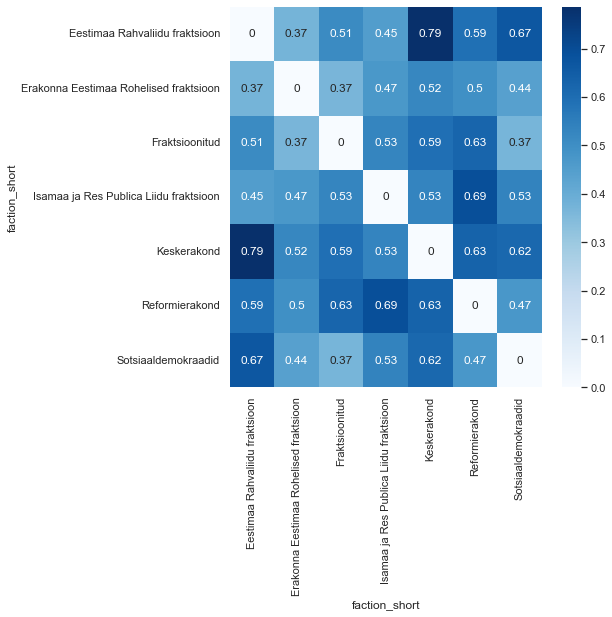

2011
num row 6


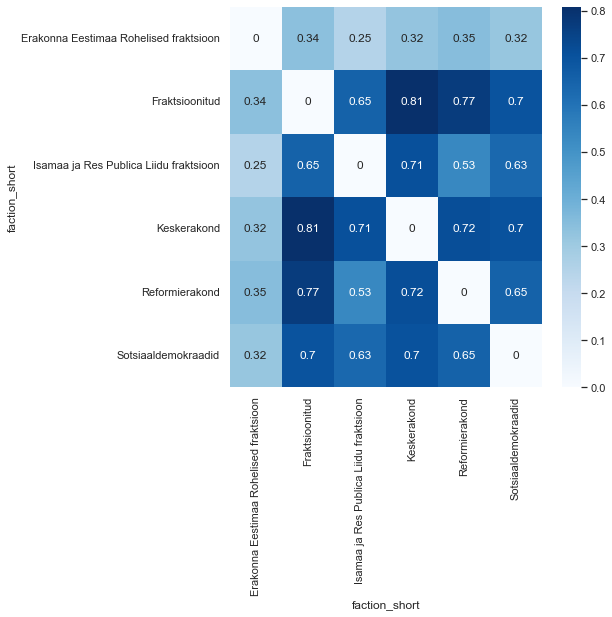

2012
num row 5


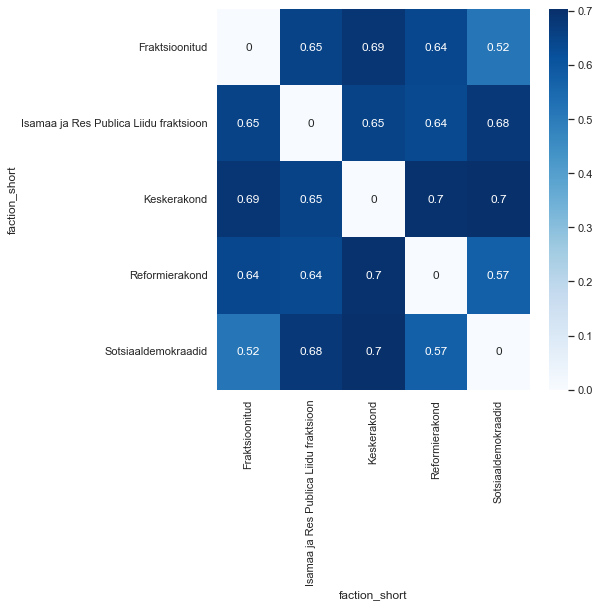

2013
num row 5


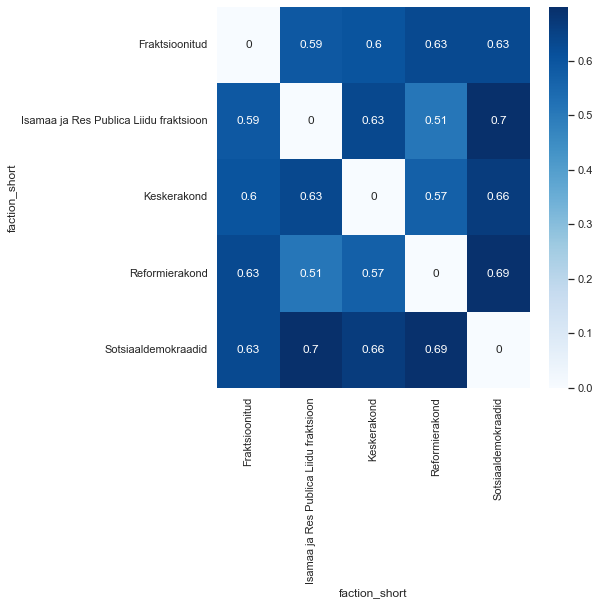

2014
num row 5


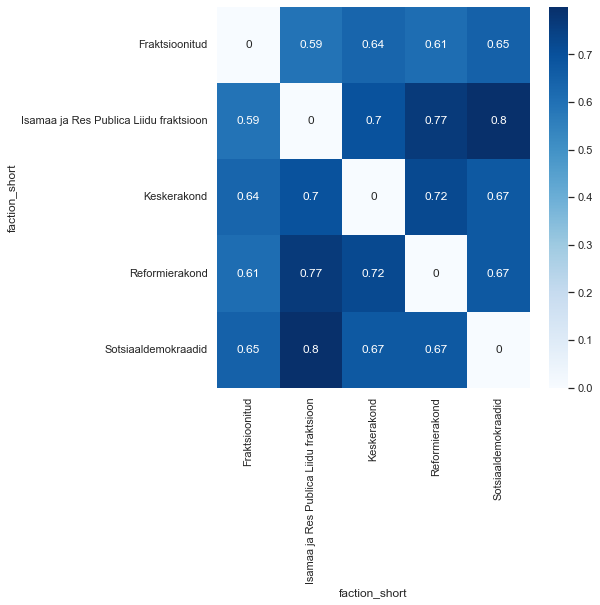

2015
num row 8


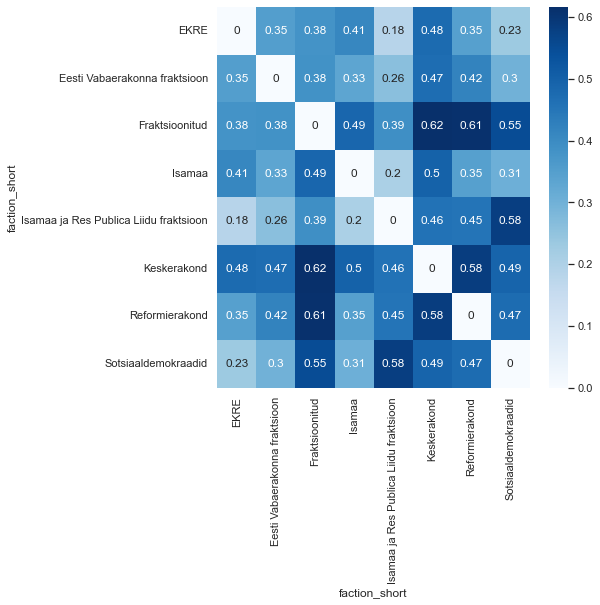

2016
num row 7


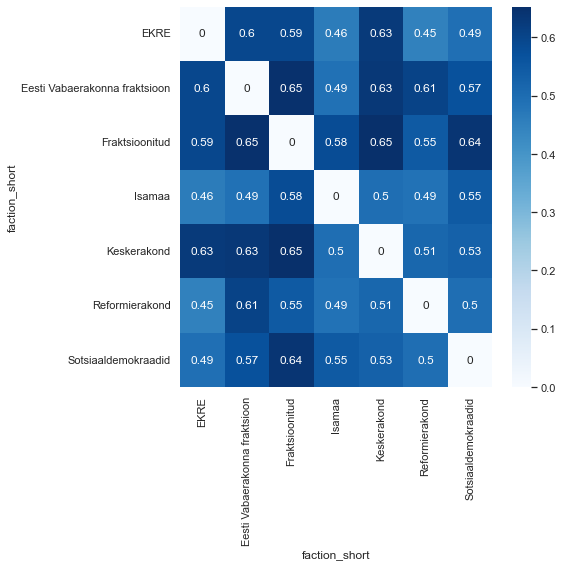

2017
num row 7


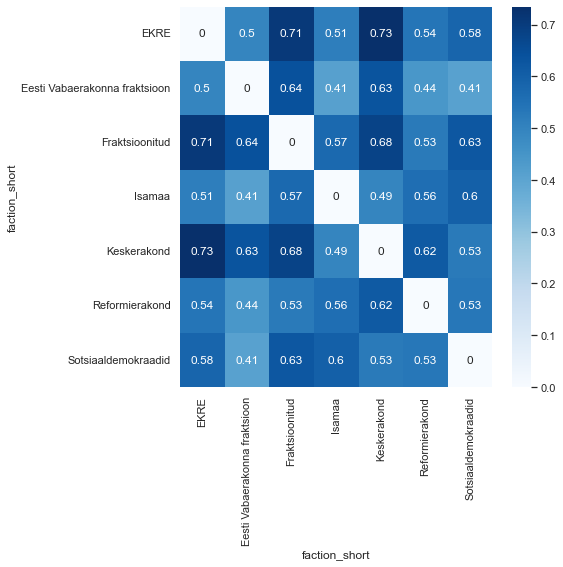

2018
num row 7


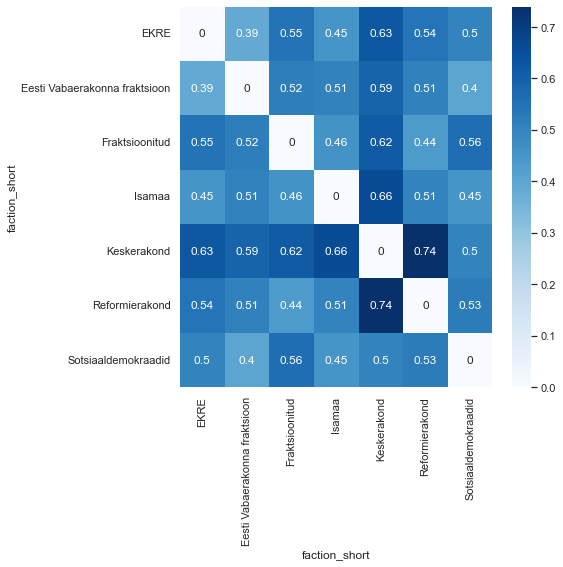

2019
num row 7


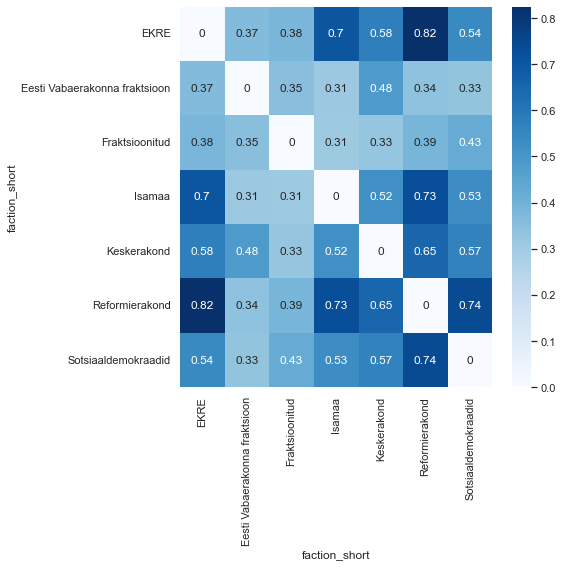

2020
num row 6


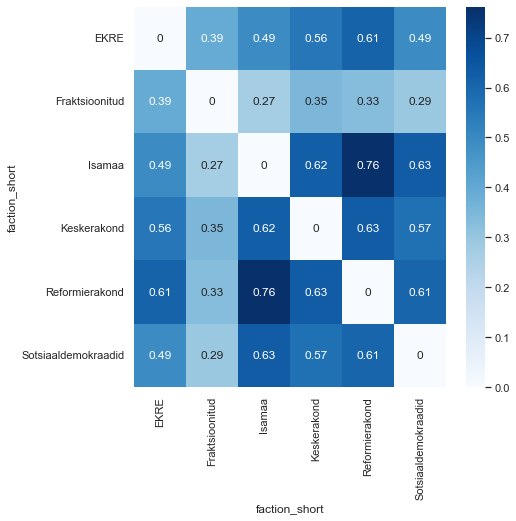

2021
num row 6


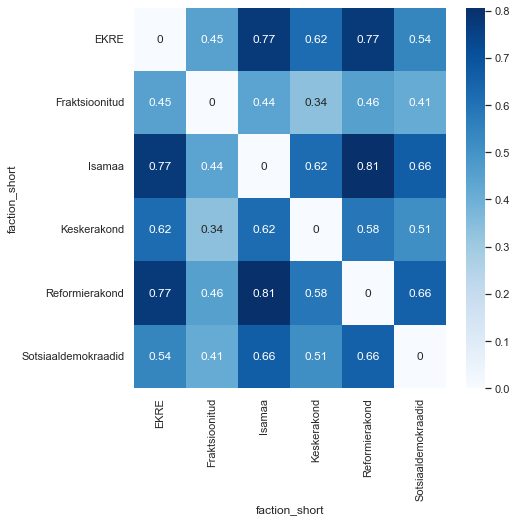

2022
num row 6


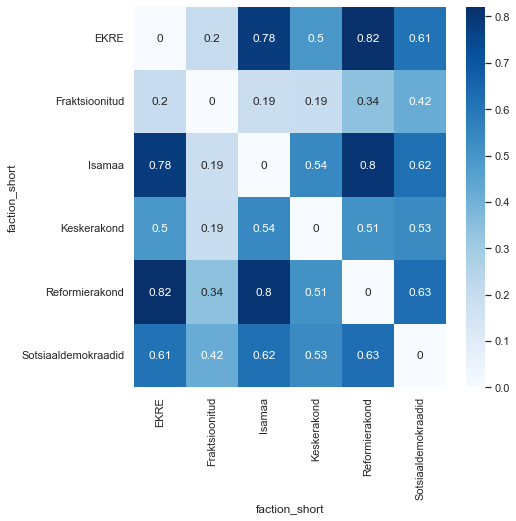

In [109]:
df_all_faction_cossims=pd.DataFrame()
faction_topic_vecs_years={} #for further analysis
for year in sorted(df_w_factions.year.unique()):
    df_faction_topic_vecs_, df_faction_topic_cossim_=create_plot_group_topvecs(df_w_factions[df_w_factions.year==year],
                                                                               N_TOPICS, fillna=0,
                                                                               group_col='faction_short')
    faction_topic_vecs_years[year]=df_faction_topic_vecs_
    #df_fation_topics_=get_group_topics_prop(df_w_factions[df_w_factions.year==year], 'fation', N_TOPICS)
    #df_faction_topic_vecs_, df_faction_topic_cossim_=create_plot_group_topvecs(df_fation_topics_,N_TOPICS, fillna=0)
    df_all_faction_cossims=pd.merge(df_all_faction_cossims, df_faction_topic_cossim_, 
                                    left_index=True, right_index=True, how='outer', 
                                    suffixes=('', f'_{year}'))
    print(year)
    print(f'num row {df_faction_topic_cossim_.shape[0]}')
    plt.show()

Keskerakond


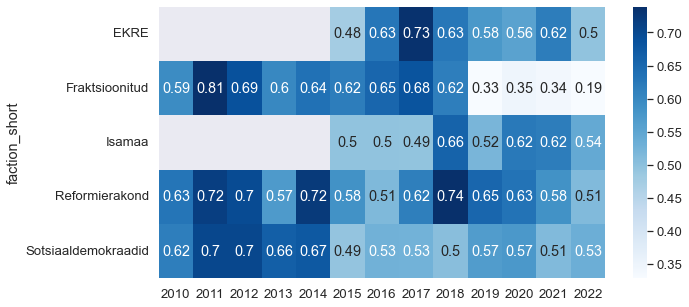

EKRE


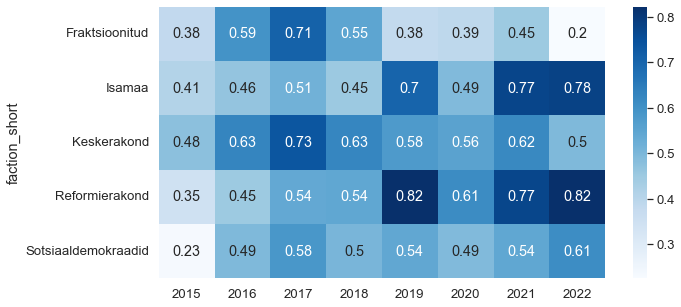

Reformierakond


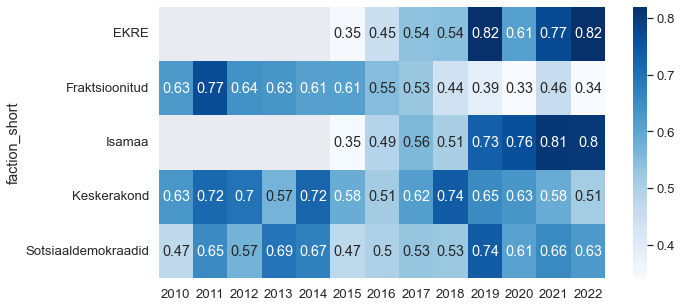

Isamaa


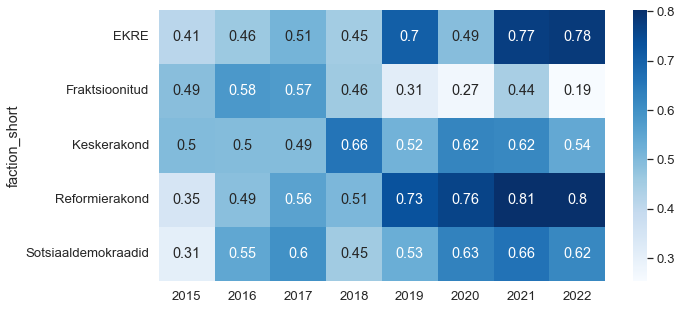

Sotsiaaldemokraadid


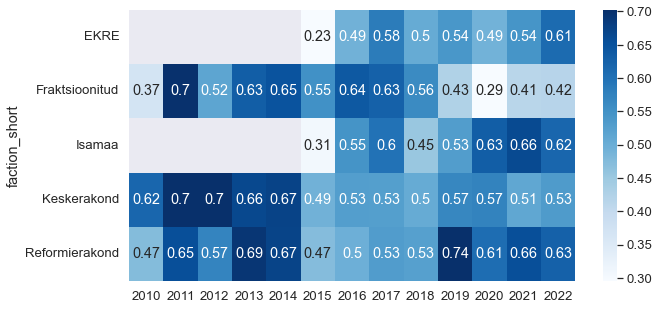

Fraktsioonitud


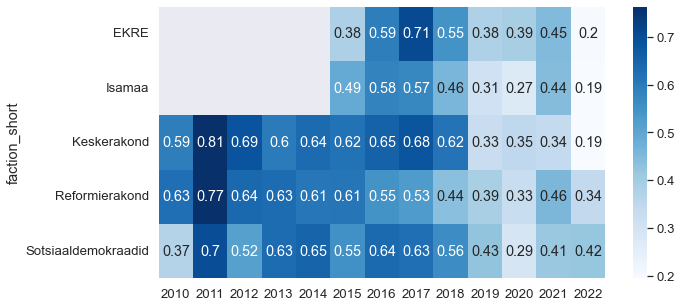

In [103]:
#plot yearly dynamics of cosine similarity
df_all_faction_cossims_sub=df_all_faction_cossims.loc[:,~df_all_faction_cossims.columns.str.startswith('Isamaa ja Res Publica Liidu')]
sns.set(font_scale = 1.2)
for faction in factions2keep.values():
    print(faction)
    fig, ax =plt.subplots(figsize=(10,5))
    faction_cols = [col for col in df_all_faction_cossims_sub.columns if faction in col]
    df_faction=df_all_faction_cossims_sub[faction_cols]
    df_faction=df_faction[df_faction.index.isin(factions2keep.values())]
    df_faction=df_faction[df_faction.index!=faction]
    columns=[c.split('_')[-1] for c in df_faction.columns]
    columns[0]=int(columns[1])-1
    df_faction.columns=columns
    sns.heatmap(df_faction, cmap='Blues', robust=True, annot=True, ax=ax)
    plt.show()

In [105]:
df_faction_topic_vecs=df_faction_topics[['fation','topic_words3', 'count']].pivot_table(values='count',
                                                                                       index='topic_words3', 
                                                                                       columns='fation')

In [106]:
df_faction_topic_vecs=df_faction_topic_vecs.fillna(0)

## Faction differences in years

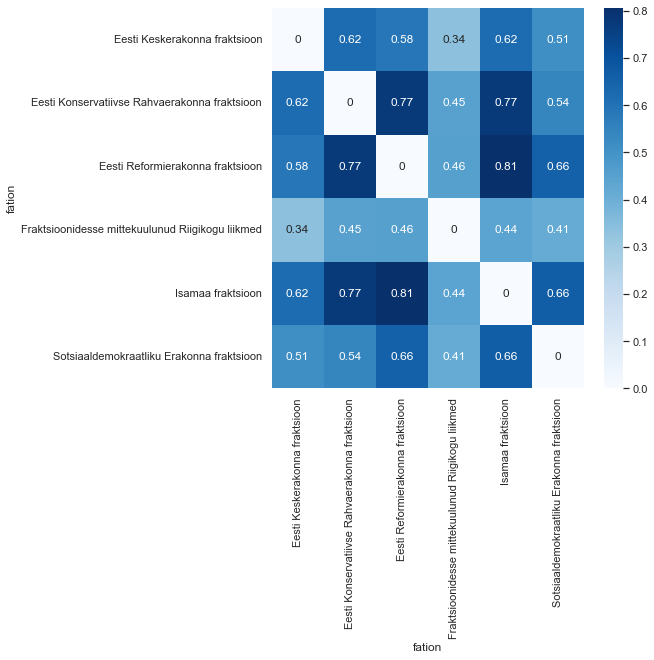

In [107]:
YEAR=2021
df_faction_topic_vecs_2021, df_faction_topic_cossim_2021=create_plot_group_topvecs(df_w_factions[df_w_factions.year==2021],
                                                                              N_TOPICS, fillna=0, )

In [108]:
#save data for FS difference caclulation
df_faction_topic_vecs_2021.to_csv('data/interim/trending/factions/yearly/2021/faction_topic_vecs_2021.csv')

In [111]:
for year in faction_topic_vecs_years.keys():
    print(year)
    df_=faction_topic_vecs_years[year]
    df_.to_csv(f'data/interim/trending/factions/yearly/{year}/faction_topic_vecs_{year}.csv')

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


#### 2011

In [115]:
simdiff_kesk_fraktsioonitud_2011=pd.read_csv('data/interim/trending/factions/yearly/2011/simdiff_Fraktsioonitud_Keskerakond_2011.csv')
simdiff_ref_fraktsioonitud_2011=pd.read_csv('data/interim/trending/factions/yearly/2011/simdiff_Fraktsioonitud_Reformierakond_2011.csv')

In [114]:
simdiff_kesk_fraktsioonitud_2011[(simdiff_kesk_fraktsioonitud_2011.difference>-20.0)&(simdiff_kesk_fraktsioonitud_2011.difference<20.0)]

,topic_words3,Fraktsioonitud,Keskerakond,difference
38,domeenide domeeni interneti,0.009940,0.011576,-16.455922
46,tulubaasi tasandusfondi tulumaksuosa,0.017893,0.019590,-9.488473
47,opositsioonis koalitsiooni opositsiooni,0.009940,0.010686,-7.497774
48,korterid kortereid korterit,0.003976,0.004452,-11.976848
49,tulubaasi omavalitsustele omavalitsuste,0.015905,0.016028,-0.779163
50,post posti omniva,0.007952,0.008014,-0.779163
51,arengukavad arengukavade pohialuste,0.007952,0.008014,-0.779163
52,etv saateid pbk,0.001988,0.001781,10.418522
53,ene ergma aplaus,0.001988,0.001781,10.418522
54,kandidaadi kandidaati kandidaat,0.001988,0.001781,10.418522


In [116]:
simdiff_ref_fraktsioonitud_2011[(simdiff_ref_fraktsioonitud_2011.difference>-20.0)&(simdiff_ref_fraktsioonitud_2011.difference<20.0)]

,topic_words3,Fraktsioonitud,Reformierakond,difference
49,arengufond arengufondi arengufondis,0.003976,0.004651,-16.976744
50,otsevalimise presidenti presidendi,0.003976,0.004651,-16.976744
51,inflatsiooni inflatsioon hinnatous,0.003976,0.004651,-16.976744
52,rahvuse rahvust rahvusriik,0.003976,0.004651,-16.976744
53,direktiivi direktiiv ulevotmise,0.003976,0.004651,-16.976744
54,psuhhiaatri alaealine psuhhiaatrilist,0.003976,0.004651,-16.976744
55,valimisliitude volikogusse volikokku,0.005964,0.006202,-3.979328
56,slovakkia ungari portugal,0.009940,0.009302,6.418605
72,erimargistatud kutust kutuse,0.017893,0.015504,13.350560
78,efsf esm kreekale,0.055666,0.046512,16.445183


<AxesSubplot:>

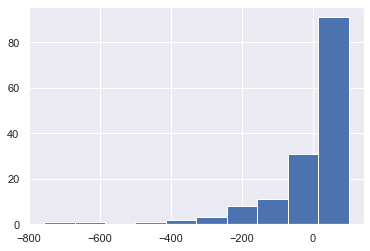

In [120]:
simdiff_ref_fraktsioonitud_2011[simdiff_ref_fraktsioonitud_2011.difference>-np.inf].difference.hist()

## Calculate similarity of speakers

In [60]:
df_inform=df[(~df.topic_cluster.isin(clusters_noninform))&(~df.topic_id.isin(topics_noninform))]
speaker_counts=df_inform.speaker.value_counts()
speaker_counts.shape

(695,)

<AxesSubplot:>

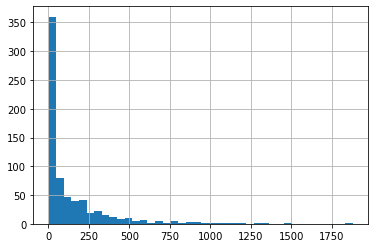

In [61]:
speaker_counts.hist(bins=40)

In [62]:
speaker_counts.describe()

count    695.000000 
mean     139.237410 
std      229.036454 
min      1.000000   
25%      9.000000   
50%      41.000000  
75%      184.000000 
max      1881.000000
Name: speaker, dtype: float64

In [63]:
#keep speakers who have enough data to compare
MIN_N_SEGMENTS=100
speakers_filtered=speaker_counts[speaker_counts>MIN_N_SEGMENTS]
df_speakers_filt=df_inform[df_inform.speaker.isin(list(speakers_filtered.index))]
df_speakers_filt.shape, df_speakers_filt.speaker.nunique()

((86318, 25), 249)

In [64]:
df_speaker_topics=get_group_topics_prop(df_speakers_filt, 'speaker', 
                                        n_topics_per_group=df_speakers_filt.speaker.nunique())
df_speaker_topic_vecs=create_group_vecs(df_speaker_topics, group_col='speaker', fillna=0)

In [65]:
df_speaker_topics.shape, df_speaker_topic_vecs.shape

((23202, 4), (256, 249))

#### cluster speakers based on topics

In [66]:
reducer = umap.UMAP(random_state=42,n_components=4, metric='cosine')
embedding=reducer.fit_transform(df_speaker_topic_vecs.T)

In [67]:
#create 2d for visualization
reducer_2d = umap.UMAP(random_state=42,n_components=2, metric='cosine')
embedding_2d=reducer_2d.fit_transform(df_speaker_topic_vecs.T)

In [68]:
df_speaker_embedding=pd.DataFrame(embedding_2d)

In [69]:
#cluster data
clusterer = hdbscan.HDBSCAN()

In [70]:
clusterer.fit(pd.DataFrame(embedding))

HDBSCAN()

In [71]:
df_speaker_embedding['speaker']=df_speaker_topic_vecs.T.index
df_speaker_embedding['label']=clusterer.labels_
df_speaker_embedding['label_color']=df_speaker_embedding.label.apply(lambda x: colors[x])
df_speaker_embedding.shape

(249, 5)

In [72]:
#number of clusters
df_speaker_embedding.label.nunique()

14

In [73]:
df_speaker_embedding

,0,1,speaker,label,label_color
0,13.693436,13.246423,Aadu Must,3,darkorange
1,14.542329,8.931796,Ain Lutsepp,1,darkmagenta
2,9.892005,12.805812,Aivar Kokk,11,darkviolet
3,14.732650,9.038327,Aivar Riisalu,1,darkmagenta
4,9.405340,11.996966,Aivar Sõerd,11,darkviolet
...,...,...,...,...,...
244,15.270149,11.253157,Välisminister Urmas Reinsalu,2,darkolivegreen
245,12.953678,12.957911,Yana Toom,3,darkorange
246,13.290545,14.143823,Yoko Alender,3,darkorange
247,11.777964,10.203660,Õiguskantsler Indrek Teder,8,darkslateblue


In [74]:
df_speaker_embedding.label.value_counts()

-1     52
 3     31
 5     30
 11    23
 4     22
 9     16
 1     13
 2     11
 0     10
 12    10
 10    9 
 7     8 
 8     7 
 6     7 
Name: label, dtype: int64

In [75]:
df_speaker_embedding[df_speaker_embedding.label==0]

,0,1,speaker,label,label_color
18,11.775587,6.457350,Aseesimees Enn Eesmaa,0,darkkhaki
19,11.455017,6.646468,Aseesimees Hanno Pevkur,0,darkkhaki
20,11.677352,6.518062,Aseesimees Helir-Valdor Seeder,0,darkkhaki
21,11.643548,6.510684,Aseesimees Jüri Ratas,0,darkkhaki
22,11.611263,6.583851,Aseesimees Laine Randjärv,0,darkkhaki
23,11.398531,6.741222,Aseesimees Martin Helme,0,darkkhaki
35,11.622769,6.519792,Esimees Eiki Nestor,0,darkkhaki
36,11.478252,6.629584,Esimees Ene Ergma,0,darkkhaki
37,11.521387,6.551674,Esimees Henn Põlluaas,0,darkkhaki
38,11.534305,6.523025,Esimees Jüri Ratas,0,darkkhaki


In [76]:
df_speaker_embedding[df_speaker_embedding.speaker.str.contains('Kaja Kallas')]

,0,1,speaker,label,label_color
91,13.109004,11.636521,Kaja Kallas,5,darkred
166,12.423191,11.563149,Peaminister Kaja Kallas,5,darkred


In [77]:
df_speaker_embedding[df_speaker_embedding.speaker.str.contains('Jüri Ratas')]

,0,1,speaker,label,label_color
21,11.643548,6.510684,Aseesimees Jüri Ratas,0,darkkhaki
38,11.534305,6.523025,Esimees Jüri Ratas,0,darkkhaki
165,12.380655,11.819221,Peaminister Jüri Ratas,5,darkred


####  plot each speaker topic embedding

<AxesSubplot:xlabel='0', ylabel='1'>

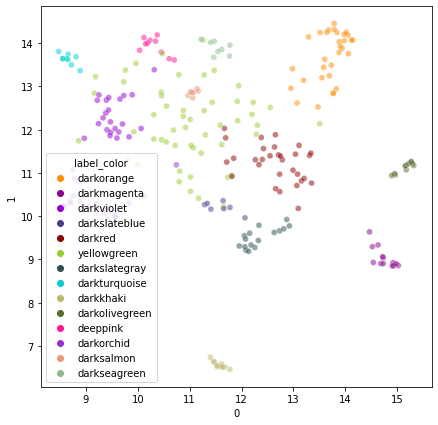

In [78]:
alpha=0.5
figsize=(7,7)
#df_speaker_embedding.plot.scatter(x=0, y=1, color='label')
fig, ax =plt.subplots(figsize=figsize)
sns.scatterplot(x=df_speaker_embedding[0], y=df_speaker_embedding[1], ax=ax,
                hue=df_speaker_embedding['label_color'],
                palette=df_speaker_embedding['label_color'].unique().tolist(),
                alpha=alpha)

#### make plotly graph for interactive visualization

In [79]:
# Create a trace containing the scatter plot
scatter = go.Scatter(x = df_speaker_embedding[0], y = df_speaker_embedding[1], mode = 'markers', \
                   marker= dict(size= 18, color = df_speaker_embedding['label_color'],\
                   line = dict(width = 2, color = 'rgb(0, 0, 0)')),
                   text = df_speaker_embedding['speaker']+' cluster id: '+df_speaker_embedding['label'].astype(str))

# Collect the trace(s) into the data to be plotted.
data = [scatter]

# Edit the layout
layout = dict(title = 'Speaker topic embeddings',
              xaxis = dict(title = 'x'),
              yaxis = dict(title = 'y'),
              hovermode = 'closest',
              )

# Define the figure
fig = dict(data=data, layout=layout)

# Save figure and layout into html file
plot_url = plotly.offline.plot(fig, filename='visualisations/scatter_speaker_topic_embeddings.html')
py.plot(fig, filename='scatter_speaker_topic_embeddings', auto_open = True)

'https://plotly.com/~risto.hinno/332/'